# Agrupamento de Ementas Legislativas de Sorocaba-SP usando Diferentes Métodos de Extração de Características e Algoritmos de Agrupamento

Sorocaba, situada no estado de São Paulo, possui um complexo conjunto de leis municipais que abrangem uma ampla gama de tópicos. Estas leis, que regulamentam desde questões urbanísticas até políticas de saúde e educação, representam um vasto corpus textual. A análise e interpretação desse corpus é fundamental não apenas para profissionais do direito e legisladores, mas também para cidadãos que buscam compreender seus direitos e obrigações no contexto municipal.

O principal objetivo deste projeto é avaliar e comparar a eficácia de diferentes algoritmos de extração de características e de agrupamento na segmentação das leis municipais de Sorocaba com base em seu conteúdo textual. Ao fazer isso, buscamos identificar padrões e temas comuns, facilitando a análise e categorização das leis.

Neste notebook, exploramos três técnicas amplamente reconhecidas de extração de características:

* **TF-IDF (Term Frequency-Inverse Document Frequency):** Uma técnica consagrada em processamento de linguagem natural que converte textos em vetores numéricos, dando peso às palavras conforme sua frequência no documento e sua raridade no corpus completo.

* **Doc2Vec:** Um modelo que representa documentos como vetores no espaço, capturando a semântica e as relações entre as palavras no documento.

* **BERTimbau:** Uma variação do modelo BERT pré-treinado especificamente para o português brasileiro, que é capaz de converter textos em representações vetoriais densas, capturando nuances contextuais.

Para cada técnica de extração de características, aplicamos três algoritmos de agrupamento distintos:

1. **K-Means:** Uma abordagem particional que procura segmentar os dados em clusters pré-definidos, minimizando a distância intra-cluster e maximizando a distância inter-cluster.

2. **DBSCAN:** Um algoritmo que se baseia na densidade para agrupar pontos que estão próximos entre si e identificar pontos que estão isolados em regiões de baixa densidade como outliers.

3. **Hierarchical Clustering:** Uma técnica que cria uma hierarquia de clusters, representada por um dendrograma, permitindo visualizar a estrutura dos dados em diferentes níveis de granularidade.
Ao final desta série de notebooks, esperamos fornecer insights claros sobre quais combinações de algoritmos de extração de características e de agrupamento são mais eficazes para agrupar e interpretar as leis municipais de Sorocaba.

## Instalação de Bibliotecas

Para a execução deste notebook, será necessário instalar algumas bibliotecas que não são padrão na maioria dos ambientes Python. Estas incluem gensim (para Doc2Vec), transformers (para BERTimbau) e torchvision (uma dependência para alguns modelos de deep learning).

Execute os comandos abaixo para instalar as bibliotecas necessárias:

In [1]:
%pip install gensim
%pip install transformers
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Importações e Configurações Iniciais

Antes de mergulharmos na análise, vamos importar as bibliotecas necessárias e realizar algumas configurações iniciais:

- **pandas:** Utilizada para manipulação e análise de dados.
  
- **numpy:** Biblioteca para suporte de arrays e matrizes multidimensionais, juntamente com uma coleção de funções matemáticas para operar nesses arrays.

- **torch:** Biblioteca de aprendizado profundo que fornece uma plataforma flexível para construção e treinamento de modelos de aprendizado de máquina.

- **gensim:** Biblioteca usada para modelagem de tópicos e análise semântica profunda. Aqui, será usada para a implementação do Doc2Vec.

- **transformers:** Fornece arquiteturas e modelos para trabalhar com NLP, incluindo BERT e suas variantes, como o BERTimbau.

- **sklearn:** Uma das bibliotecas mais populares para machine learning em Python, usada aqui para a extração de características dos textos e para a implementação dos algoritmos de clusterização.

- **matplotlib** e **seaborn:** Usadas para criação de visualizações e gráficos.

Vamos proceder com as importações:

In [2]:
import pandas as pd
import numpy as np
import torch
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

## Carregamento e Pré-processamento dos Dados

Primeiro, vamos carregar nossos dados e inspecionar as primeiras entradas para entender sua estrutura.

In [3]:
# Carregando os dados:
df = pd.read_csv("./data/Leis de Sorocaba (Preprocessed).csv").sample(frac=0.25, random_state=42).reset_index(drop=True)

# Removendo os valores nulos:
df = df.dropna()

# Verificando as primeiras linhas do dataframe:
df.head()

,summary
0,dispõe sobre denominação pedro elias espíndola...
1,autoriza prefeitura ceder mediante concessão a...
2,dispõe sobre denominação etelvina vieira miran...
3,desobriga mulheres gestantes estado avançado g...
4,estabelece estrutura funcionamento conselho tu...


Existem muitas observações com termos que não agregam valor para nossa análise. Vamos remover estes termos:

In [4]:
# Removendo termos irrelevantes:
remove_phrases = ['dispõe sobre', 'dá outras providências']
remove_phrases_regex = '|'.join(remove_phrases)
df['summary'] = df['summary'].str.replace(remove_phrases_regex, ' ', regex=True).str.strip()

## Extração de Características

### TF-IDF

**TF-IDF** é a abreviação de **Term Frequency-Inverse Document Frequency**. É uma técnica estatística usada para determinar a importância de uma palavra em um documento, dentro de um corpus. O valor do TF-IDF aumenta proporcionalmente ao número de vezes que uma palavra aparece no documento, mas é compensado pela frequência da palavra no corpus. Isso ajuda a ajustar o fato de que algumas palavras aparecem mais frequentemente em geral.

O TF-IDF é calculado da seguinte forma:

1. **Term Frequency (TF)**: É a frequência relativa de uma palavra em um documento em relação ao total de palavras no mesmo documento. É calculado como:

$$
TF(t) = \frac{\text{Número de vezes que o termo t aparece no documento}}{\text{Número total de termos no documento}}
$$

2. **Inverse Document Frequency (IDF)**: É o logaritmo da razão total de documentos pelo número de documentos contendo o termo. O IDF diminui o peso de palavras que ocorrem muito frequentemente nos documentos e aumenta o peso de palavras que ocorrem raramente. É calculado como:

$$
IDF(t) = \log \frac{\text{Número total de documentos}}{\text{Número de documentos com o termo t}}
$$

Portanto, o TF-IDF é o produto de TF e IDF:

$$
TFIDF(t) = TF(t) \times IDF(t)
$$

#### Principais Parâmetros

Quando usamos o TF-IDF em bibliotecas como o `sklearn`, existem vários parâmetros que podemos ajustar:

1. **max_features**: Define o número máximo de termos que devem ser retidos. É útil quando estamos lidando com textos muito extensos, pois podemos limitar o número de características a serem consideradas, mantendo apenas os termos mais relevantes.

2. **stop_words**: São palavras que são filtradas antes ou depois do processamento do texto. Palavras comuns como "e", "é", "de", entre outras, que não contêm informações significativas, são geralmente removidas.

3. **max_df**: Ignora os termos que aparecem em mais do que uma fração especificada dos documentos. Por exemplo, se definido como 0.85, ele ignorará termos que aparecem em mais de 85% dos documentos.

4. **min_df**: Semelhante ao `max_df`, mas nesse caso, ele ignora os termos que aparecem em menos do que uma fração especificada dos documentos.

5. **ngram_range**: Define o intervalo de n-grams a serem extraídos. Por exemplo, se definido como (1, 2), ele extrairá unigrams e bigrams.

#### Importância para o Desempenho

Ajustar os parâmetros do TF-IDF é crucial para obter uma boa representação dos textos. Uma representação inadequada pode prejudicar o desempenho dos algoritmos de clusterização. Por exemplo:

- **Removendo palavras irrelevantes**: Usar `stop_words` e ajustar `max_df` e `min_df` pode ajudar a remover termos que são muito comuns ou muito raros, respectivamente. Esses termos muitas vezes não agregam valor significativo à análise.

- **Considerando bigrams ou trigrams**: Às vezes, a combinação de palavras pode ter um significado diferente do das palavras individuais. Por exemplo, "alta" e "pressão" podem não ser muito informativas individualmente, mas juntas, como "alta pressão", podem ser muito relevantes.

- **Limitando o número de características**: Em grandes conjuntos de dados, a dimensão do espaço de características pode se tornar muito alta, o que pode prejudicar o desempenho de certos algoritmos devido à "maldição da dimensionalidade". Limitar o número de características usando `max_features` pode ajudar a mitigar esse problema.

#### Análise da Frequência dos Termos

Antes de proceder com a clusterização, é crucial compreender a distribuição dos termos em nosso corpus. Isso nos permite fazer ajustes informados, melhorando a qualidade da representação textual e, consequentemente, os resultados da clusterização.

In [5]:
# Usando CountVectorizer para obter a frequência de documentos de cada termo
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(df['summary'])

# Calculando a frequência de documentos para cada termo
df_freq = np.sum(X_count > 0, axis=0)
df_freq = np.squeeze(np.asarray(df_freq))

##### Histograma da Frequência dos Termos

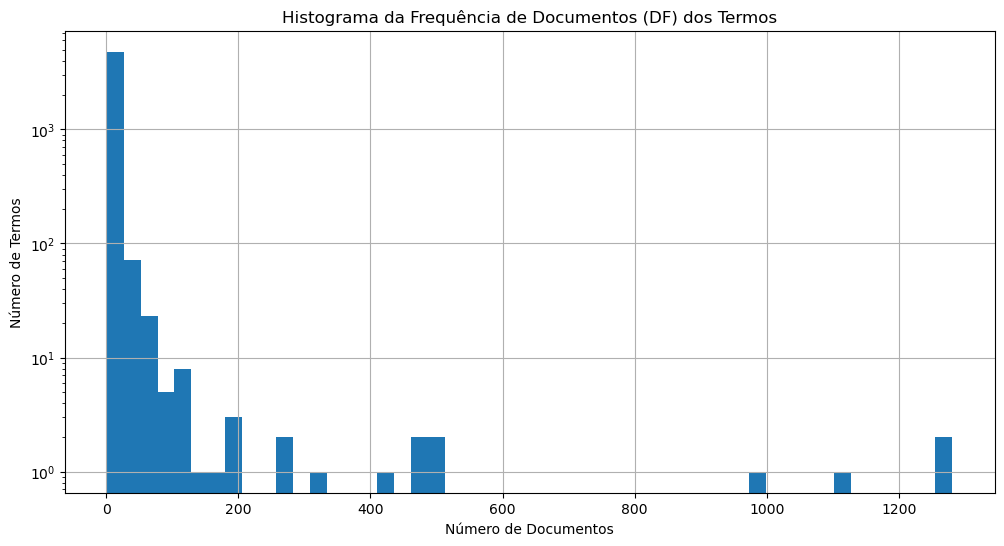

In [6]:
# Plotando o histograma da frequência de documentos
plt.figure(figsize=(12, 6))
plt.hist(df_freq, bins=50, log=True)  # Usamos escala logarítmica no eixo y para melhor visualização
plt.title("Histograma da Frequência de Documentos (DF) dos Termos")
plt.xlabel("Número de Documentos")
plt.ylabel("Número de Termos")
plt.grid(True)
plt.show()

##### Histograma Log-Log da Frequência de Documentos (DF) dos Termos

O segundo histograma, em uma escala log-log, mostra a distribuição das frequências de documentos para os termos em nosso corpus. A frequência de documentos de um termo é o número de documentos diferentes em que esse termo aparece.

A observação da distribuição nos informa:

* Há mais de mil ($10^3$) termos que aparecem em apenas um documento ($10^0$), indicando a presença de termos muito específicos ou possivelmente ruidosos.

* Aproximadamente 100 ($10^2$) termos aparecem em 10 documentos ($10^1$), sugerindo termos que ainda são relativamente raros.

* Mais de 10 ($10^1$) termos ocorrem em 100 documentos ($10^2$), representando termos mais comuns.

* A partir de 1000 ($10^3$) documentos em diante, vemos que a maioria dos termos está concentrada em torno de 1 ($10^0$), indicando que poucos termos são extremamente comuns no corpus.

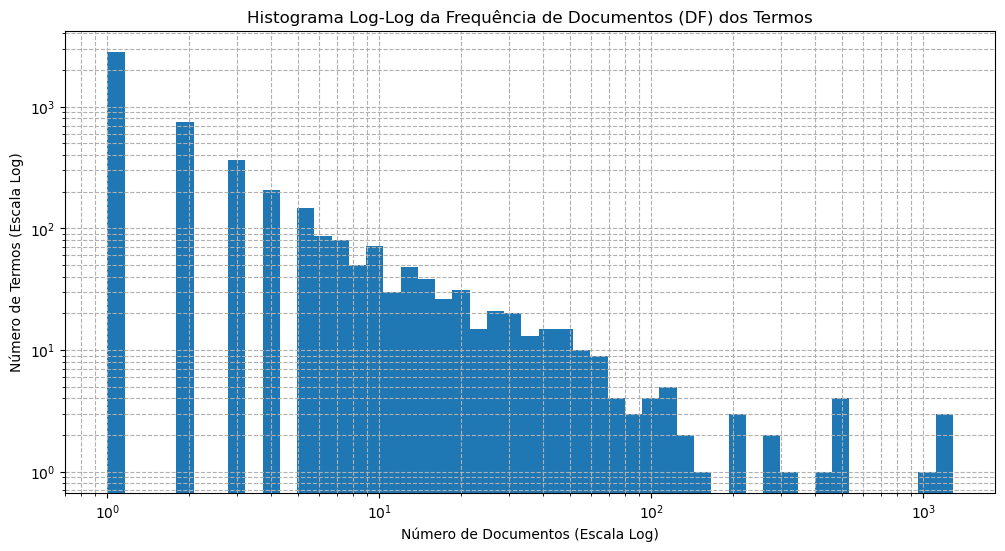

In [7]:
plt.figure(figsize=(12, 6))
plt.hist(df_freq, bins=np.logspace(np.log10(1), np.log10(df_freq.max()+1), 50), log=True)
plt.yscale("log")
plt.title("Histograma Log-Log da Frequência de Documentos (DF) dos Termos")
plt.xlabel("Número de Documentos (Escala Log)")
plt.ylabel("Número de Termos (Escala Log)")
plt.xscale("log")
plt.grid(True, which="both", ls="--")
plt.show()

##### Conclusão
Com base na análise acima:

* **Estimativa de `min_df`:** Dado o grande número de termos que aparecem em apenas um documento, consideraríamos ajustar o min_df para um valor maior que 1. Um valor inicial como 5 ou 10 poderia ser considerado, com o objetivo de filtrar termos que aparecem em menos de 5 ou 10 documentos, respectivamente. Podemos também utilizar um valor percentual do total de documentos, como 0.01 ou 0.05.

* **Estimativa de `max_df`:** Devido à presença de termos extremamente comuns que aparecem em muitos documentos (por exemplo, em mais de $10^3$ documentos), podemos considerar ajustar o max_df para filtrar tais termos. Um valor como 0.7 ou 0.8 do total de documentos pode ser uma boa escolha inicial.

Estas são recomendações iniciais e, como sempre, a experimentação com diferentes valores e a avaliação dos clusters resultantes nos fornecerá uma visão mais clara sobre as melhores configurações.

#### Implementação do TF-IDF

Nesta seção, transformaremos nossos textos brutos em representações numéricas usando o TF-IDF. A configuração escolhida para o vetorizador é baseada em nossa análise exploratória anterior:

- **max_features=500**: Limitamos a representação a 500 características (termos) para manter apenas os termos mais relevantes.

- **stop_words=None**: Não aplicamos a remoção de stopwords neste passo, pois já tratamos disso anteriormente.

- **ngram_range=(1, 3)**: Além de termos individuais (unigrams), também consideramos combinações de até 3 palavras (trigrams) para capturar contextos mais amplos.

- **max_df=0.80**: Ignoramos termos que aparecem em mais de 80% dos documentos, pois são muito comuns e podem não ser discriminativos.

- **min_df=10**: Ignoramos termos que aparecem em menos de 10 documentos para filtrar raridades ou ruídos.

Ao final desta transformação, cada documento será representado por um vetor numérico, onde cada valor indica a importância relativa de um termo no documento em relação ao corpus como um todo.

In [8]:
vectorizer = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 3),
    max_df=0.8,
    min_df=10
    )
X_tfidf = vectorizer.fit_transform(df['summary'])


### Doc2Vec

**Doc2Vec**, também conhecido como **Paragraph2Vec** ou **Sentence Embeddings**, é uma extensão do modelo Word2Vec para documentos ou sequências de palavras maiores do que um único termo. Enquanto o Word2Vec gera uma representação vetorial para cada palavra no vocabulário, o Doc2Vec gera uma representação vetorial para cada documento no corpus.

A ideia por trás do Doc2Vec é representar um documento como uma combinação de:

1. Um vetor que representa o próprio documento.

2. Vetores para palavras individuais no documento.

Os vetores são aprendidos de forma que representações semelhantes de palavras e documentos estejam próximas no espaço vetorial.

#### Principais Parâmetros

Quando usamos o Doc2Vec em bibliotecas como `gensim`, existem vários parâmetros que podemos ajustar:

1. **vector_size**: Define o número de dimensões do vetor de saída.

2. **window**: Máximo de distância entre a palavra atual e as palavras previstas dentro de uma sentença.

3. **min_count**: Ignora todas as palavras com frequência total inferior a este.

4. **workers**: Número de núcleos do CPU a serem usados para treinar o modelo.

5. **epochs**: Número de iterações (épocas) sobre o corpus.

#### Importância para o Desempenho

Ajustar os parâmetros do Doc2Vec é fundamental para obter representações de alta qualidade dos documentos:


- **Tamanho do vetor**: Escolher um tamanho de vetor adequado é crucial. Tamanhos muito pequenos podem não capturar toda a informação, enquanto tamanhos muito grandes podem levar a overfitting.

- **Janela**: Uma janela maior pode capturar mais contexto, mas também pode incluir informações menos relevantes.

- **Frequência mínima de palavras**: Filtrar palavras raras pode ajudar a focar nas palavras mais informativas.

#### Implementação do Doc2Vec

Para representar nossos documentos usando Doc2Vec, precisamos seguir alguns passos:

1. **Preparar os dados**: Cada documento deve ser tokenizado (dividido em palavras) e associado a uma etiqueta única. No nosso caso, estamos usando o índice do documento como etiqueta, o que garante a unicidade. As etiquetas são úteis não só durante o treinamento, mas também quando queremos inferir vetores para novos documentos.

In [9]:
# Preparando os dados
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['summary'].apply(lambda x: x.split(" ")))]

2. **Treinar o modelo Doc2Vec nos dados preparados**: Uma vez que os dados estão formatados corretamente, procedemos com o treinamento do modelo Doc2Vec. Durante esse processo, o modelo tenta aprender representações vetoriais para os documentos de tal forma que o contexto das palavras dentro dos documentos seja preservado.

   - **vector_size=100**: Escolhemos uma representação de tamanho 100 para cada documento. Isso é uma escolha intermediária e geralmente funciona bem para muitos datasets. Valores típicos para vector_size variam de 50 a 300. Uma representação de maior dimensão poderia capturar mais nuances, mas também pode levar a maior complexidade e risco de sobreajuste.
   
   - **window=5**: O tamanho da janela de contexto foi definido como 5, o que significa que, para cada palavra, o modelo considerará 5 palavras anteriores e 5 palavras subsequentes como contexto. Valores comuns para window estão na faixa de 5 a 10.
   
   - **min_count=5**: Ignoramos palavras que aparecem em menos de 5 documentos. Esse parâmetro ajuda a filtrar palavras raras ou específicas demais que poderiam não ser úteis para a representação geral.
   
   - **workers=4**: Número de núcleos de CPU usados para treinar o modelo. Isso é específico para otimizar o tempo de treinamento.
   
   - **epochs=100**: Número de iterações sobre o corpus durante o treinamento. Um número maior de épocas pode permitir que o modelo aprenda melhor, mas também corre o risco de sobreajuste se for muito alto.

In [10]:
# Treinando o modelo Doc2Vec
model = Doc2Vec(vector_size=100, window=5, min_count=5, workers=4, epochs=100)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)


3. **Obter a representação vetorial para cada documento**: Após o treinamento, o modelo tem a capacidade de representar cada documento como um vetor no espaço que aprendeu. Usamos o método `infer_vector` para obter essas representações para cada um dos nossos documentos. Esses vetores são o que usaremos para as análises subsequentes e agrupamento.

In [11]:
# Obtendo a representação vetorial para cada documento
X_doc2vec = np.array([model.infer_vector(doc.words) for doc in documents])

### BERTimbau

**BERTimbau** é uma adaptação do modelo BERT (Bidirectional Encoder Representations from Transformers) pré-treinado especificamente para o português. O BERT é uma arquitetura de Processamento de Linguagem Natural (PLN) que utiliza transformers e atenção para entender o contexto das palavras em um texto. Ao contrário dos modelos anteriores, como Word2Vec ou Doc2Vec, que aprendem representações para palavras ou documentos individualmente, o BERT é capaz de considerar o contexto completo de uma palavra em uma frase, tornando-o especialmente poderoso para tarefas de compreensão de texto.

#### Principais Parâmetros

Ao utilizar o BERTimbau ou qualquer variante do BERT, existem vários parâmetros e considerações a serem observados:

1. **Modelo pré-treinado**: O BERT é geralmente pré-treinado em um grande corpus e depois adaptado (fine-tuned) para tarefas específicas. O BERTimbau é uma dessas variantes pré-treinadas, otimizada para o português.
2. **Tamanho do tokenizador**: BERT utiliza um tokenizador que pode quebrar palavras em subpalavras ou caracteres, permitindo uma cobertura efetiva de um vasto vocabulário com um tamanho de modelo menor.
3. **Camadas e tamanho do modelo**: Existem diferentes tamanhos de BERT disponíveis, variando em termos de número de camadas e tamanho do modelo. Modelos maiores geralmente oferecem melhor desempenho, mas são mais computacionalmente intensivos.
4. **Sequência máxima de comprimento**: BERT tem uma limitação de comprimento de sequência (geralmente 512 tokens). Textos mais longos precisam ser truncados ou divididos.

#### Importância para o Desempenho

A adaptação correta do BERT para sua tarefa específica é fundamental para aproveitar ao máximo o poder deste modelo:

- **Fine-tuning**: Embora o BERTimbau seja pré-treinado, adaptar o modelo aos seus dados específicos (fine-tuning) pode melhorar significativamente o desempenho.
- **Comprimento da Sequência**: A limitação de comprimento do BERT significa que a escolha de como lidar com documentos longos (truncando, dividindo ou combinando) pode impactar o desempenho.
- **Uso de camadas**: O BERT tem várias camadas, e diferentes camadas capturam diferentes tipos de informações. Experimentar com saídas de diferentes camadas pode ser benéfico dependendo da tarefa.

#### Implementação do BERTimbau

Para representar nossos documentos usando BERTimbau:

1. **Carregamento do Tokenizador e Modelo:** Carregamos o tokenizador e o modelo específico do BERTimbau, que serão usados para processar e extrair características dos textos.

In [12]:
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = BertModel.from_pretrained("neuralmind/bert-base-portuguese-cased")

2. **Definição da Função de Extração:** Criamos uma função chamada extract_embedding que realiza a tokenização do texto e, em seguida, o alimenta através do modelo BERTimbau para obter a representação vetorial.

In [13]:
def extract_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Utilizaremos o CLS token (primeira posição) como a representação do texto
    return outputs['last_hidden_state'][0][0].numpy()

3. **Aplicação da Função e Obtenção das Representações:** Usamos a função `extract_embedding` para processar cada texto do dataframe. O resultado é uma lista de vetores que representam os textos.

In [14]:
X_bertimbau = np.array([extract_embedding(text) for text in df['summary']])

## Clusterização

### K-Means

O K-Means é um dos algoritmos de agrupamento mais populares e é categorizado como particional. O objetivo do algoritmo é dividir um conjunto de pontos em `K` grupos (ou clusters) de densidade semelhante. O "K" em K-Means refere-se ao número de clusters que o algoritmo tentará identificar.

O funcionamento do algoritmo é iterativo:

1. **Inicialização:** Escolha `K` pontos do conjunto de dados como os centroides iniciais dos clusters.

2. **Atribuição:** Atribua cada ponto ao centróide mais próximo, formando `K` clusters.

3. **Recálculo:** Calcule o ponto médio (centróide) de cada cluster.

4. **Repetição:** Repita os passos 2 e 3 até que os centroides não mudem significativamente ou até que um número máximo de iterações seja alcançado.

Uma das decisões mais cruciais ao usar K-Means é a escolha do valor de `K`, ou seja, o número de clusters a serem formados.

#### Escolhendo o valor de `K` - Método do Cotovelo

Uma das técnicas mais comuns para determinar o número ótimo de clusters é o método do cotovelo. O método envolve executar a clusterização K-Means no conjunto de dados para um intervalo de valores de `K` (por exemplo, `K` de 1 a 10), e para cada valor de `K`, a inércia (ou soma dos erros quadráticos dentro dos clusters) é calculada. Essas inércias são então plotadas em um gráfico.

O "cotovelo" do gráfico representa um ponto de inflexão onde a taxa de diminuição da inércia se estabiliza, indicando que adicionar mais clusters não resultará em uma melhoria significativa do ajuste. O valor de `K` no "cotovelo" é considerado um bom indicador do número ótimo de clusters.

Entretanto, a escolha do número de clusters não é apenas uma questão técnica. A interpretabilidade dos clusters, a experiência de domínio e outros fatores contextuais também devem ser considerados ao tomar a decisão.

In [15]:
def plot_elbow_method(X, extractor_name):
    """
    Função para plotar o método do cotovelo para determinar o K ótimo.
    
    Parâmetros:
    X: Matriz de características.
    extractor_name: Nome do método de extração de características (e.g., "TF-IDF", "Doc2Vec", "BERTimbau").
    """
    inertia = []
    for i in range(1, 15):
        kmeans = KMeans(n_clusters=i, n_init=10, random_state=42).fit(X)
        inertia.append(kmeans.inertia_)
        
    plt.figure(figsize=(10,6))
    plt.plot(range(1, 15), inertia)
    plt.xlabel('Número de clusters')
    plt.ylabel('Inércia')
    plt.title(f'Método do cotovelo para K ótimo no {extractor_name}')
    plt.show()

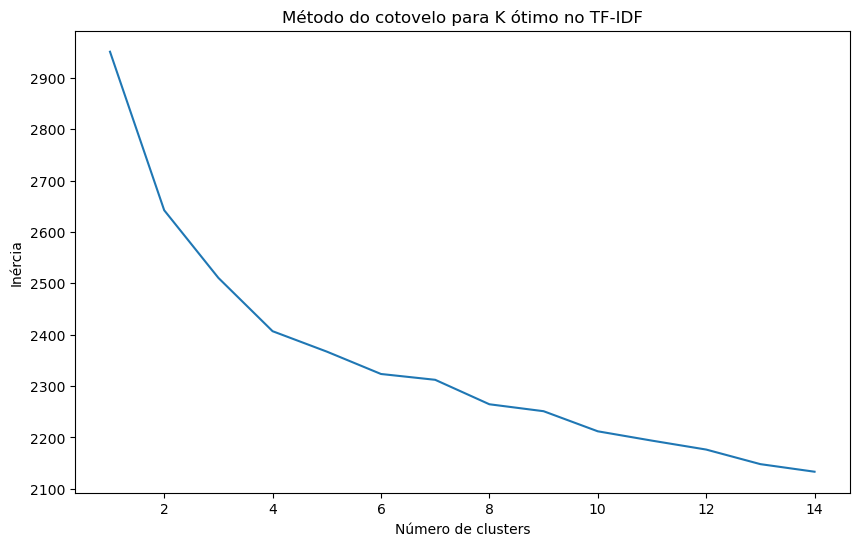

In [16]:
plot_elbow_method(X_tfidf.toarray(), "TF-IDF")

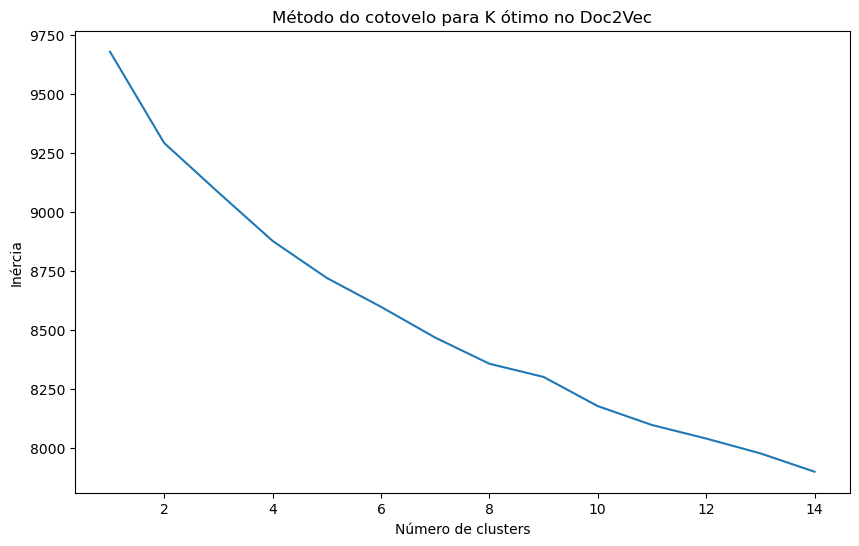

In [17]:
plot_elbow_method(X_doc2vec, "Doc2Vec")

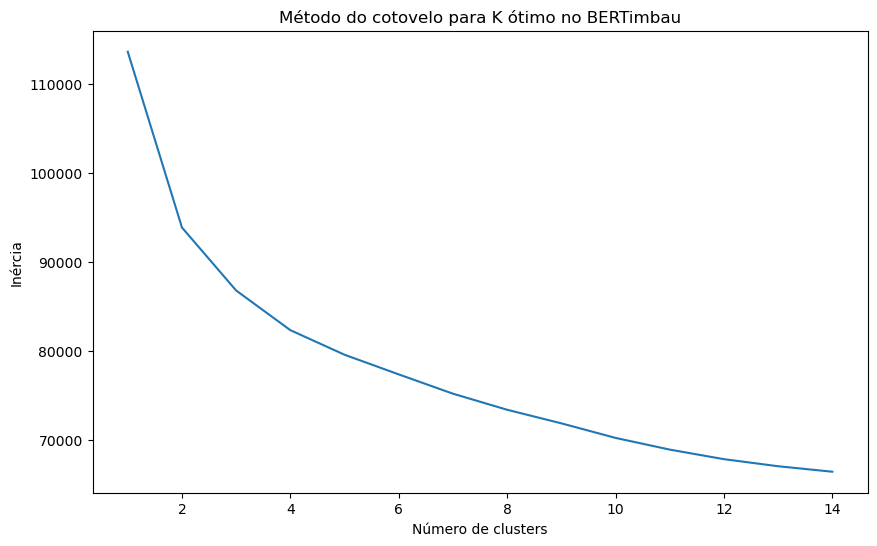

In [18]:
plot_elbow_method(X_bertimbau, "BERTimbau")

#### Escolha do Valor de `K` Baseado no Domínio do Problema

Em cenários onde técnicas quantitativas não fornecem um indicador claro para o número ideal de clusters (como acima), o conhecimento do domínio se torna uma ferramenta inestimável. 

No contexto da clusterização de leis municipais, tal conhecimento é especialmente crucial, dada a natureza complexa e multifacetada dos textos legais. Assim, usamos uma categorização fornecida por um especialista no domínio, que sugere agrupar as leis por temas específicos.

Os agrupamentos detalhados estão disponíveis no documento anexo `Grupos temáticos de legislação`. Com base neles, identificamos 11 temas principais:

1. Leis Orçamentárias e Créditos Adicionais

2. Título de Utilidade Pública

3. Teor Tributário

4. Dias Temáticos

5. Denominações de Próprios Públicos

6. Estrutura da Administração Pública e Servidores Públicos

7. Títulos Honoríficos

8. Urbanismo e Obras

9. Revogações

10. Normas sobre Bancos

11. Alterações de Artigos

Portanto, escolhemos `K = 11` para a clusterização, alinhando as leis diretamente com os agrupamentos temáticos. Essa decisão garante que a segmentação seja relevante, significativa e matematicamente coerente com os objetivos da análise.


In [19]:
NUM_CLUSTERS = 11

# Para o TF-IDF
kmeans_tfidf = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(X_tfidf)
df['kmeans_labels_tfidf'] = kmeans_tfidf.labels_

# Para o Doc2Vec
kmeans_doc2vec = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(X_doc2vec)
df['kmeans_labels_doc2vec'] = kmeans_doc2vec.labels_

# Para o BERTimbau
kmeans_bertimbau = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(X_bertimbau)
df['kmeans_labels_bertimbau'] = kmeans_bertimbau.labels_

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### DBSCAN

O DBSCAN (Density-Based Spatial Clustering of Applications with Noise) é um algoritmo de clusterização baseado em densidade que pode identificar clusters de forma e tamanho variáveis. Ao contrário de métodos centróides como o K-means, que são sensíveis à forma dos clusters, o DBSCAN trabalha identificando regiões densas no espaço de dados.

#### Principais características e vantagens do DBSCAN:

1. **Densidade:** Ao invés de agrupar com base na distância média de pontos a um centróide, o DBSCAN identifica clusters como regiões de alta densidade separadas por regiões de baixa densidade.

2. **Número de Clusters:** Não requer a especificação do número de clusters a priori. Ele determina o número de clusters com base nos dados e nos parâmetros fornecidos.

3. **Ruído:** É capaz de identificar e tratar pontos de ruído, ou seja, observações que não pertencem a nenhum cluster.

4. **Forma Variável:** Pode identificar clusters de formas e tamanhos variáveis, tornando-o particularmente útil para conjuntos de dados com agrupamentos de forma irregular.

#### Parâmetros principais:

* **eps:** Define a distância máxima entre duas amostras para que uma seja considerada na vizinhança da outra. Um valor pequeno pode resultar em muitos pequenos clusters, enquanto um valor muito grande pode resultar em união de clusters distintos.

* **min_samples:** O número mínimo de amostras (ou peso total) em uma vizinhança para um ponto de dados ser considerado como núcleo. Isso inclui o próprio ponto.

Uma das principais considerações ao usar o DBSCAN é a escolha adequada de eps e min_samples. Uma má escolha desses parâmetros pode levar a resultados subótimos de clusterização.

#### Estimativa do Parâmetro `eps` usando a Distância do k-ésimo Vizinho Mais Próximo

Uma das principais dificuldades ao usar o algoritmo DBSCAN é determinar um valor adequado para o parâmetro epsilon (ou eps). Uma técnica comum para estimar esse valor é utilizar a distância do k-ésimo vizinho mais próximo.

##### O processo funciona da seguinte maneira:

1. Para cada ponto, calcule a distância até o k-ésimo vizinho mais próximo (neste exemplo, k=50).

2. Ordene estas distâncias em ordem crescente.

3. Plote as distâncias.

O ponto de inflexão máximo neste gráfico, muitas vezes referido como "cotovelo", é uma boa indicação do valor de epsilon a ser usado. Em outras palavras, é o ponto onde um aumento na distância do k-ésimo vizinho mais próximo começa a mostrar taxas de crescimento mais acentuadas, indicando a distância entre pontos de dados em clusters densos e pontos de dados em regiões de baixa densidade ou ruído.

##### No código fornecido:

* Utilizamos o NearestNeighbors do scikit-learn para encontrar os k-vizinhos mais próximos de cada ponto.
* As distâncias são então ordenadas e plotadas para visualização.

Ao examinar o gráfico resultante, você deve buscar o ponto onde a curva começa a subir rapidamente. Este ponto representa uma boa estimativa para o valor de epsilon.

In [20]:
def plot_knn_distances(X, extractor_name, k=5):
    """
    Função para plotar as distâncias do k-ésimo vizinho mais próximo.
    
    Parâmetros:
    X: Matriz de características.
    extractor_name: Nome do método de extração de características (e.g., "TF-IDF", "Doc2Vec", "BERTimbau").
    k: k-ésimo vizinho. Valor padrão é 5.
    """
    # Inicializando o modelo NearestNeighbors com k vizinhos
    nearest_neighbors = NearestNeighbors(n_neighbors=k)

    # Ajustando o modelo aos dados
    nearest_neighbors.fit(X)

    # Obtendo as distâncias e índices dos k vizinhos mais próximos de cada ponto
    distances, indices = nearest_neighbors.kneighbors(X)

    # Ordenando as distâncias para cada ponto
    distances = np.sort(distances, axis=0)

    # Selecionando as distâncias do k-ésimo vizinho mais próximo
    distances = distances[:,1]

    # Plotando as distâncias ordenadas
    plt.figure(figsize=(10,6))
    plt.plot(distances)
    plt.title(f'Distâncias para o {k}º Vizinho Mais Próximo no {extractor_name}')
    plt.xlabel('Pontos ordenados')
    plt.ylabel(f'Distância para o {k}º vizinho mais próximo')
    plt.show()

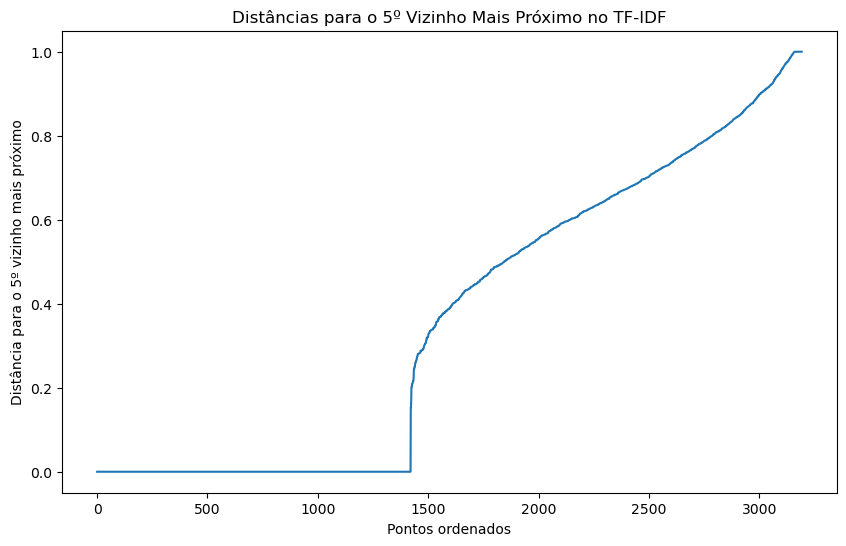

In [21]:
plot_knn_distances(X_tfidf.toarray(), "TF-IDF")

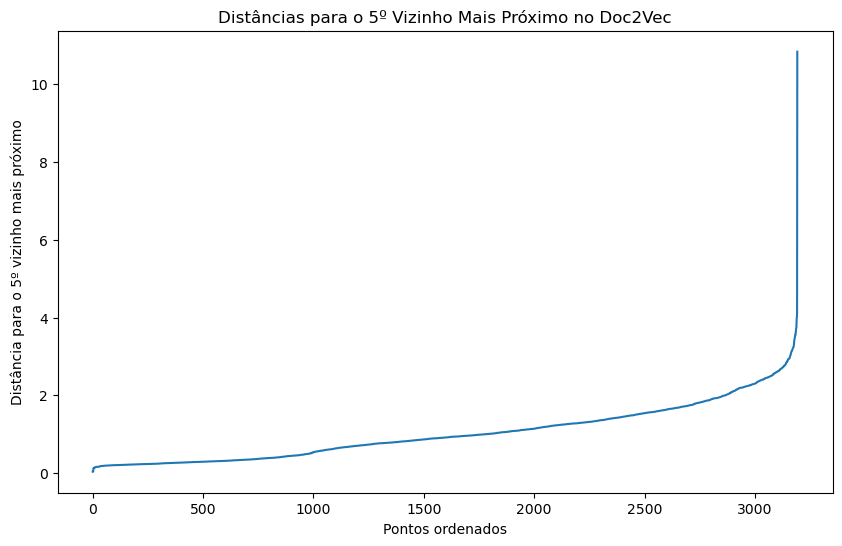

In [22]:
plot_knn_distances(X_doc2vec, "Doc2Vec")

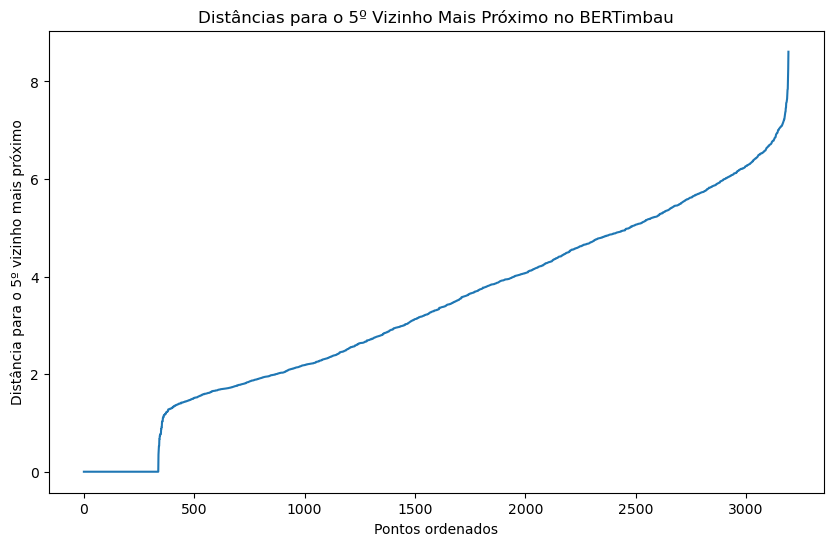

In [23]:
plot_knn_distances(X_bertimbau, "BERTimbau")

In [24]:
# Para o TF-IDF
dbscan_tfidf = DBSCAN(eps=0.1, min_samples=5).fit(X_tfidf)
df['dbscan_labels_tfidf'] = dbscan_tfidf.labels_

# Para o Doc2Vec
dbscan_doc2vec = DBSCAN(eps=1, min_samples=5).fit(X_doc2vec)
df['dbscan_labels_doc2vec'] = dbscan_doc2vec.labels_

# Para o BERTimbau
dbscan_bertimbau = DBSCAN(eps=1, min_samples=5).fit(X_bertimbau)
df['dbscan_labels_bertimbau'] = dbscan_bertimbau.labels_

### Hierarchical Clustering

O Hierarchical Clustering, ou Agrupamento Hierárquico, é uma abordagem de clusterização que busca construir uma hierarquia de clusters. Ao contrário do K-means ou DBSCAN, que são algoritmos de partição, o agrupamento hierárquico cria uma árvore de clusters, também conhecida como dendrograma.

#### Características principais:

1. **Hierarquia**: Cria uma série de clusters aninhados, permitindo uma visualização em diferentes níveis de granularidade.

2. **Não exige especificação de número de clusters**: Ao observar o dendrograma, você pode decidir o número de clusters cortando a árvore em um nível específico.

3. **Determinístico**: Diferentemente do K-means, que pode fornecer diferentes resultados em execuções diferentes, o agrupamento hierárquico é determinístico.

#### Métodos de ligação (ou aglomeração):

- **Single Linkage**: O cluster é definido pela menor distância entre dois pontos em diferentes clusters.

- **Complete Linkage**: A distância entre clusters é definida pela maior distância entre dois pontos em diferentes clusters.

- **Average Linkage**: A distância entre clusters é a média das distâncias entre os pontos nos dois clusters.

- **Ward's Method**: Busca minimizar a variância dentro do cluster.

#### Processo básico:

1. **Inicialização**: Cada ponto é considerado como um cluster individual.

2. **Aglomeração**: Na etapa seguinte, os dois clusters mais próximos são combinados em um único cluster.

3. **Iteração**: O processo é repetido até que todos os pontos estejam em um único cluster.

4. **Resultado**: O resultado é uma árvore que mostra a sequência em que os clusters foram combinados e a distância entre eles naquela etapa.

Ao usar o agrupamento hierárquico, é essencial decidir o método de ligação e a métrica de distância. A escolha destes parâmetros pode influenciar significativamente a forma e o conteúdo dos clusters resultantes.

In [31]:
# Para o TF-IDF
agg_tfidf = AgglomerativeClustering(n_clusters=NUM_CLUSTERS, linkage='ward').fit(X_tfidf.toarray())
df['agg_labels_tfidf'] = agg_tfidf.labels_

# Para o Doc2Vec
agg_doc2vec = AgglomerativeClustering(n_clusters=NUM_CLUSTERS, linkage='ward').fit(X_doc2vec)
df['agg_labels_doc2vec'] = agg_doc2vec.labels_

# Para o BERTimbau
agg_bertimbau = AgglomerativeClustering(n_clusters=NUM_CLUSTERS, linkage='ward').fit(X_bertimbau)
df['agg_labels_bertimbau'] = agg_bertimbau.labels_

## Métricas e Avaliação

Uma vez que os clusters são formados, é essencial avaliar sua qualidade. A avaliação nos permite entender o quão bem nosso algoritmo performou e também ajuda na comparação de diferentes métodos ou configurações de clusterização. Usaremos várias métricas para avaliar a coesão e separação dos clusters.

### Silhouette Score

Mede o quão similar é um objeto ao seu próprio cluster (coesão) em comparação com outros clusters (separação). Os valores variam entre -1 e 1, onde um valor alto indica que o objeto está bem pareado com seu próprio cluster e mal pareado com clusters vizinhos.

In [32]:
# Métricas para TF-IDF
silhouette_kmeans_tfidf = silhouette_score(X_tfidf, df['kmeans_labels_tfidf'])
silhouette_dbscan_tfidf = silhouette_score(X_tfidf, df['dbscan_labels_tfidf'])
silhouette_agg_tfidf = silhouette_score(X_tfidf, df['agg_labels_tfidf'])

print(f"Silhouette Score for KMeans TF-IDF: {silhouette_kmeans_tfidf}")
print(f"Silhouette Score for DBSCAN TF-IDF: {silhouette_dbscan_tfidf}")
print(f"Silhouette Score for Hierarchical Clustering TF-IDF: {silhouette_agg_tfidf}")

# Métricas para Doc2Vec
silhouette_kmeans_doc2vec = silhouette_score(X_doc2vec, df['kmeans_labels_doc2vec'])
silhouette_dbscan_doc2vec = silhouette_score(X_doc2vec, df['dbscan_labels_doc2vec'])
silhouette_agg_doc2vec = silhouette_score(X_doc2vec, df['agg_labels_doc2vec'])

print(f"Silhouette Score for KMeans Doc2Vec: {silhouette_kmeans_doc2vec}")
print(f"Silhouette Score for DBSCAN Doc2Vec: {silhouette_dbscan_doc2vec}")
print(f"Silhouette Score for Hierarchical Clustering Doc2Vec: {silhouette_agg_doc2vec}")

# Métricas para BERTimbau
silhouette_kmeans_bertimbau = silhouette_score(X_bertimbau, df['kmeans_labels_bertimbau'])
silhouette_dbscan_bertimbau = silhouette_score(X_bertimbau, df['dbscan_labels_bertimbau'])
silhouette_agg_bertimbau = silhouette_score(X_bertimbau, df['agg_labels_bertimbau'])

print(f"Silhouette Score for KMeans BERTimbau: {silhouette_kmeans_bertimbau}")
print(f"Silhouette Score for DBSCAN BERTimbau: {silhouette_dbscan_bertimbau}")
print(f"Silhouette Score for Hierarchical Clustering BERTimbau: {silhouette_agg_bertimbau}")

Silhouette Score for KMeans TF-IDF: 0.11278049931687661
Silhouette Score for DBSCAN TF-IDF: 0.005341643854393907
Silhouette Score for Hierarchical Clustering TF-IDF: 0.11344027165510064
Silhouette Score for KMeans Doc2Vec: -0.0029385408852249384
Silhouette Score for DBSCAN Doc2Vec: -0.06437329947948456
Silhouette Score for Hierarchical Clustering Doc2Vec: -0.0934876874089241
Silhouette Score for KMeans BERTimbau: 0.1611805409193039
Silhouette Score for DBSCAN BERTimbau: -0.050181496888399124
Silhouette Score for Hierarchical Clustering BERTimbau: 0.11713052541017532


### Davies-Bouldin Index

É uma métrica que indica a média da "similaridade" entre cada cluster e o cluster mais similar. A similaridade é uma medida que compara a distância entre clusters com o tamanho dos clusters em si. Valores mais baixos indicam melhores configurações de clusterização.

In [34]:
# Métricas para TF-IDF
db_kmeans_tfidf = davies_bouldin_score(X_tfidf.toarray(), df['kmeans_labels_tfidf'])
db_dbscan_tfidf = davies_bouldin_score(X_tfidf.toarray(), df['dbscan_labels_tfidf'])
db_agg_tfidf = davies_bouldin_score(X_tfidf.toarray(), df['agg_labels_tfidf'])

print(f"Silhouette Score for KMeans TF-IDF: {db_kmeans_tfidf}")
print(f"Silhouette Score for DBSCAN TF-IDF: {db_dbscan_tfidf}")
print(f"Silhouette Score for Hierarchical Clustering TF-IDF: {db_agg_tfidf}")

# Métricas para Doc2Vec
db_kmeans_doc2vec = davies_bouldin_score(X_doc2vec, df['kmeans_labels_doc2vec'])
db_dbscan_doc2vec = davies_bouldin_score(X_doc2vec, df['dbscan_labels_doc2vec'])
db_agg_doc2vec = davies_bouldin_score(X_doc2vec, df['agg_labels_doc2vec'])

print(f"Silhouette Score for KMeans Doc2Vec: {db_kmeans_doc2vec}")
print(f"Silhouette Score for DBSCAN Doc2Vec: {db_dbscan_doc2vec}")
print(f"Silhouette Score for Hierarchical Clustering Doc2Vec: {db_agg_doc2vec}")

# Métricas para BERTimbau
db_kmeans_bertimbau = davies_bouldin_score(X_bertimbau, df['kmeans_labels_bertimbau'])
db_dbscan_bertimbau = davies_bouldin_score(X_bertimbau, df['dbscan_labels_bertimbau'])
db_agg_bertimbau = davies_bouldin_score(X_bertimbau, df['agg_labels_bertimbau'])

print(f"Silhouette Score for KMeans BERTimbau: {silhouette_kmeans_bertimbau}")
print(f"Silhouette Score for DBSCAN BERTimbau: {silhouette_dbscan_bertimbau}")
print(f"Silhouette Score for Hierarchical Clustering BERTimbau: {silhouette_agg_bertimbau}")

Silhouette Score for KMeans TF-IDF: 3.3963015562949574
Silhouette Score for DBSCAN TF-IDF: 1.1271179717793194
Silhouette Score for Hierarchical Clustering TF-IDF: 3.250486825931033
Silhouette Score for KMeans Doc2Vec: 3.140378905957316
Silhouette Score for DBSCAN Doc2Vec: 5.316320076767685
Silhouette Score for Hierarchical Clustering Doc2Vec: 4.110241523475386
Silhouette Score for KMeans BERTimbau: 0.1611805409193039
Silhouette Score for DBSCAN BERTimbau: -0.050181496888399124
Silhouette Score for Hierarchical Clustering BERTimbau: 0.11713052541017532


### Tabela de Métricas

In [36]:
data = {
    "Metric": ["Silhouette Score", "Davies-Bouldin Index"],
    "TF-IDF KMeans": [silhouette_kmeans_tfidf, db_kmeans_tfidf],
    "TF-IDF DBSCAN": [silhouette_dbscan_tfidf, db_dbscan_tfidf],
    "TF-IDF Hierarchical": [silhouette_agg_tfidf, db_agg_tfidf],
    "Doc2Vec KMeans": [silhouette_kmeans_doc2vec, db_kmeans_doc2vec],
    "Doc2Vec DBSCAN": [silhouette_dbscan_doc2vec, db_dbscan_doc2vec],
    "Doc2Vec Hierarchical": [silhouette_agg_doc2vec, db_agg_doc2vec],
    "BERTimbau KMeans": [silhouette_kmeans_bertimbau, db_kmeans_bertimbau],
    "BERTimbau DBSCAN": [silhouette_dbscan_bertimbau, db_dbscan_bertimbau],
    "BERTimbau Hierarchical": [silhouette_agg_bertimbau, db_agg_bertimbau]
}

df_metrics = pd.DataFrame(data)
display(df_metrics)

,Metric,TF-IDF KMeans,TF-IDF DBSCAN,TF-IDF Hierarchical,Doc2Vec KMeans,Doc2Vec DBSCAN,Doc2Vec Hierarchical,BERTimbau KMeans,BERTimbau DBSCAN,BERTimbau Hierarchical
0,Silhouette Score,0.112780,0.005342,0.113440,-0.002939,-0.064373,-0.093488,0.161181,-0.050181,0.117131
1,Davies-Bouldin Index,3.396302,1.127118,3.250487,3.140379,5.316320,4.110242,2.613932,0.870873,2.910182


### Gráficos de Métricas

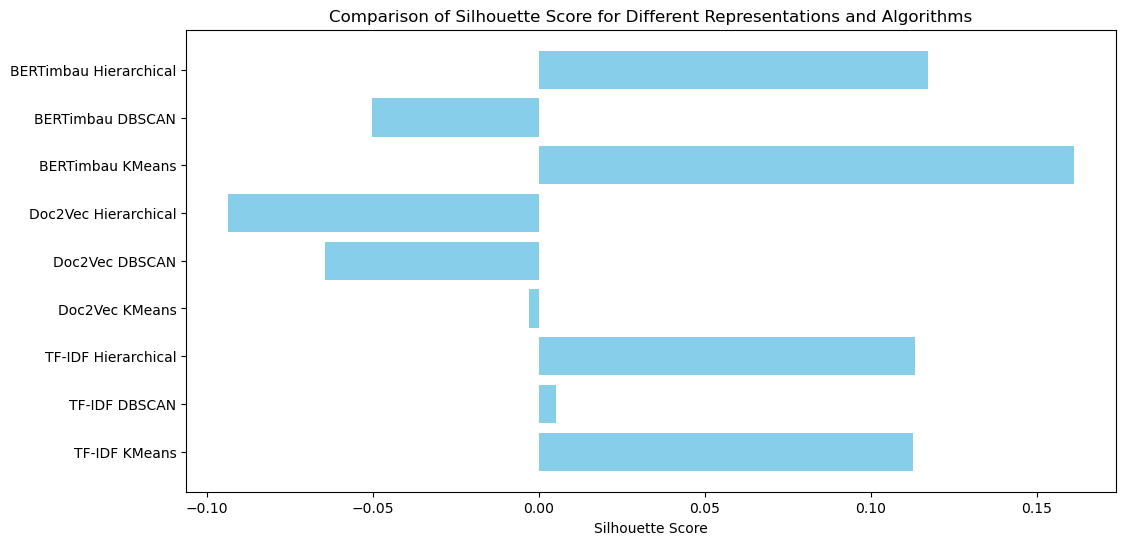

In [37]:
# Para o Silhouette Score
# Etiquetas para os diferentes métodos e algoritmos
labels = ["TF-IDF KMeans", "TF-IDF DBSCAN", "TF-IDF Hierarchical", 
          "Doc2Vec KMeans", "Doc2Vec DBSCAN", "Doc2Vec Hierarchical", 
          "BERTimbau KMeans", "BERTimbau DBSCAN", "BERTimbau Hierarchical"]

# Valores de Silhouette Score para cada combinação
scores = [silhouette_kmeans_tfidf, silhouette_dbscan_tfidf, silhouette_agg_tfidf, 
          silhouette_kmeans_doc2vec, silhouette_dbscan_doc2vec, silhouette_agg_doc2vec,
          silhouette_kmeans_bertimbau, silhouette_dbscan_bertimbau, silhouette_agg_bertimbau]

# Criação do gráfico
plt.figure(figsize=(12, 6))
plt.barh(labels, scores, color='skyblue')
plt.xlabel('Silhouette Score')
plt.title('Comparison of Silhouette Score for Different Representations and Algorithms')
plt.show()

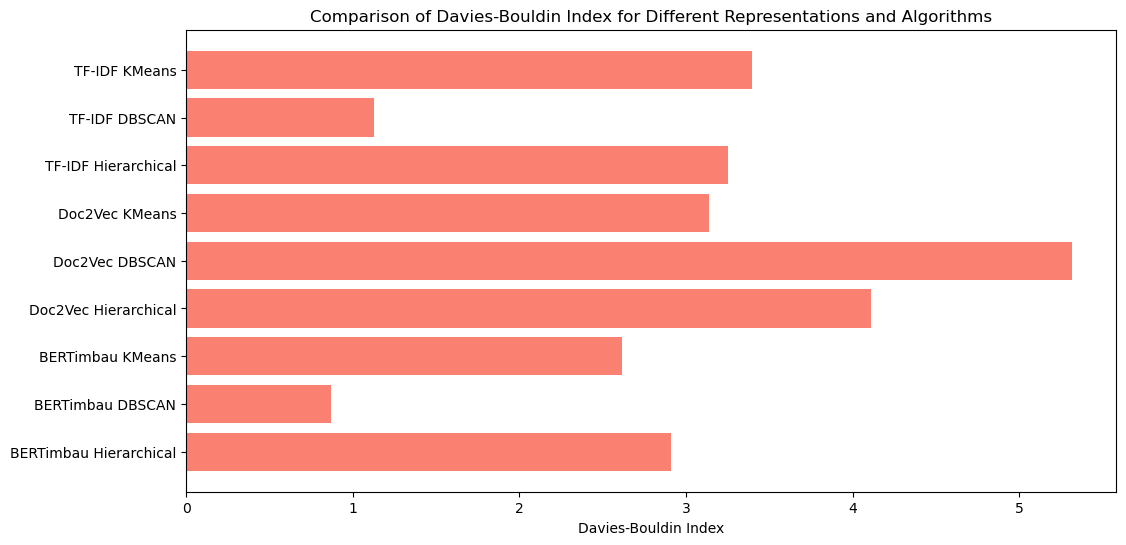

In [38]:
# Para o Davies-Bouldin Index
# Etiquetas para os diferentes métodos e algoritmos
labels = ["TF-IDF KMeans", "TF-IDF DBSCAN", "TF-IDF Hierarchical", 
          "Doc2Vec KMeans", "Doc2Vec DBSCAN", "Doc2Vec Hierarchical", 
          "BERTimbau KMeans", "BERTimbau DBSCAN", "BERTimbau Hierarchical"]

# Valores de Davies-Bouldin para cada combinação
scores_db = [db_kmeans_tfidf, db_dbscan_tfidf, db_agg_tfidf, 
             db_kmeans_doc2vec, db_dbscan_doc2vec, db_agg_doc2vec,
             db_kmeans_bertimbau, db_dbscan_bertimbau, db_agg_bertimbau]

# Criação do gráfico
plt.figure(figsize=(12, 6))
plt.barh(labels, scores_db, color='salmon')
plt.xlabel('Davies-Bouldin Index')
plt.title('Comparison of Davies-Bouldin Index for Different Representations and Algorithms')
plt.gca().invert_yaxis()  # Para os valores mais baixos (melhores) aparecerem no topo
plt.show()

## Análise Qualitativa

A Análise Qualitativa se refere à avaliação não-numérica dos clusters formados. Enquanto as métricas quantitativas (como Silhouette Score e Davies-Bouldin Index) fornecem uma medida objetiva da qualidade dos clusters, a análise qualitativa permite uma interpretação mais subjetiva e contextualizada.

Nesta seção, faremos uma análise é estruturada em três partes: visualização dos clusters, distribuição dos clusters e análise de exemplos representativos de cada cluster.

Ao revisar manualmente os clusters, podemos validar se os resultados fazem sentido no contexto das leis municipais e se estão alinhados com as expectativas e o conhecimento do domínio.

### Visualização dos Clusters

A visualização de clusters em um espaço bidimensional nos permite ter uma intuição sobre como os clusters estão distribuídos e se há uma separação clara entre eles. Uma das técnicas mais populares para essa visualização é o t-SNE (t-Distributed Stochastic Neighbor Embedding). O t-SNE é uma técnica de redução de dimensionalidade que é particularmente adequada para a visualização de conjuntos de dados de alta dimensão.

In [39]:
def compute_tsne(X_list):
    tsne_results = []
    for X in X_list:
        tsne = TSNE(n_components=2, random_state=42, init="random")
        X_tsne = tsne.fit_transform(X)
        tsne_results.append(X_tsne)
    return tsne_results

In [40]:
def plot_tsne_grid(tsne_results, labels_list, titles_list):
    # Configurações do gráfico
    plt.figure(figsize=(18, 18))
    
    # Para cada combinação de características e rótulos
    for i, (X_tsne, labels, title) in enumerate(zip(tsne_results, labels_list, titles_list)):
        # Preparando o DataFrame para visualização
        df_tsne = pd.DataFrame(data=X_tsne, columns=['Dim1', 'Dim2'])
        df_tsne['Cluster'] = labels

        # Plotando o gráfico correspondente
        plt.subplot(3, 3, i+1)
        sns.scatterplot(x="Dim1", y="Dim2", hue="Cluster", data=df_tsne, palette="tab10", legend="full", alpha=0.6)
        plt.title(title)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_29270/450699872.py:16: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


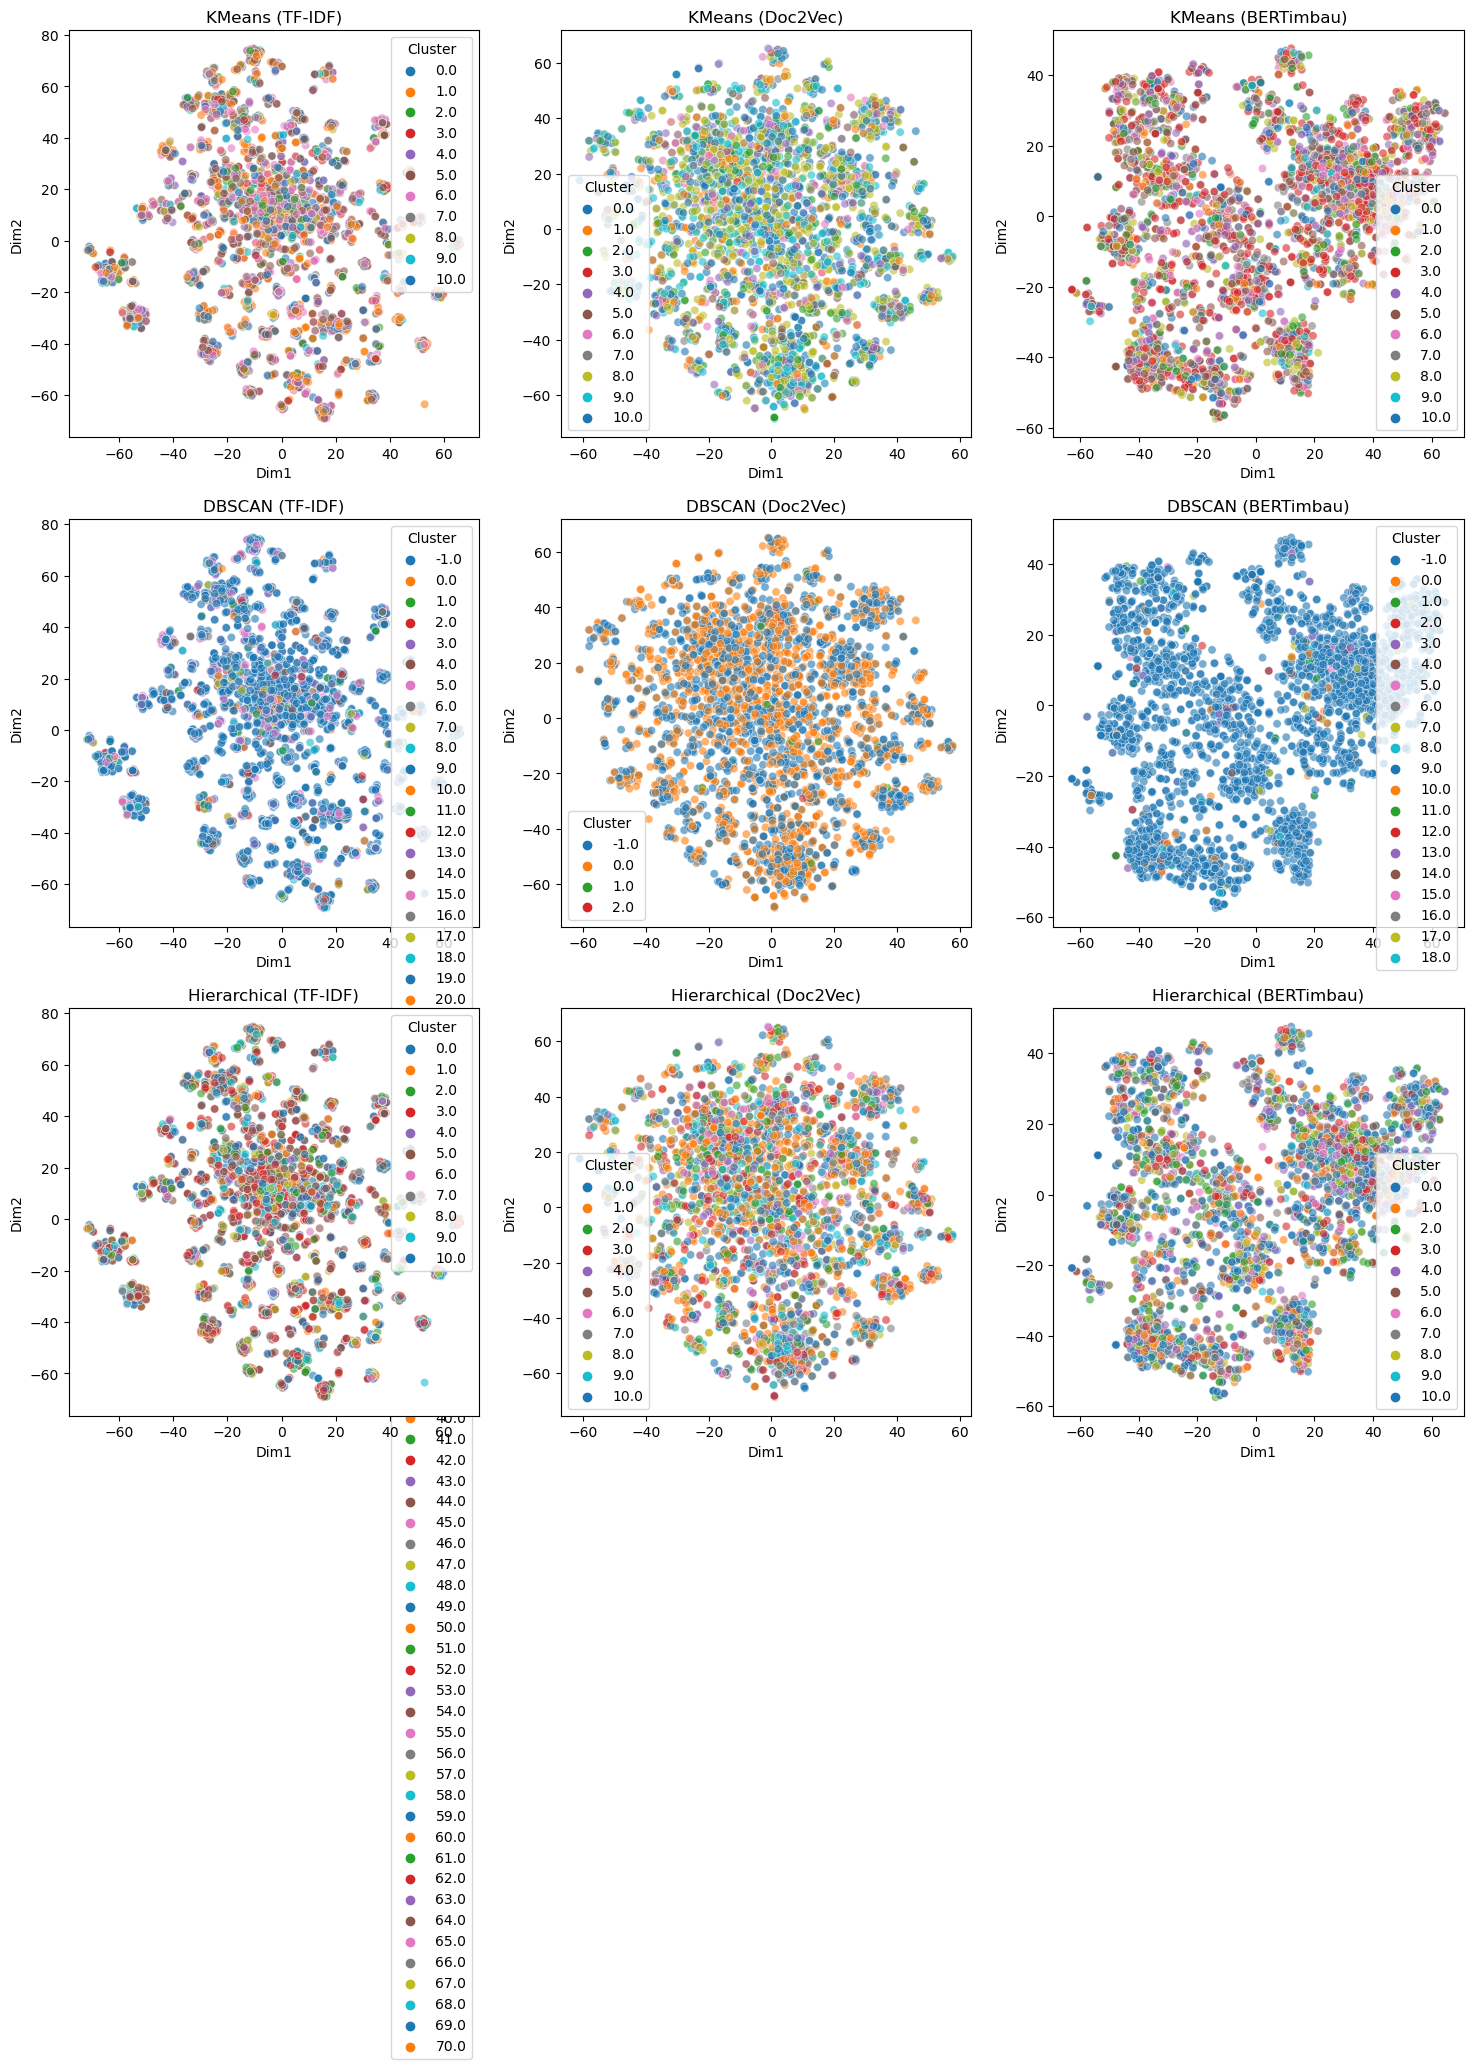

In [41]:
tsne_results = compute_tsne([X_tfidf, X_doc2vec, X_bertimbau])

# Replicando os resultados do t-SNE para cada algoritmo de clusterização
tsne_results_full = tsne_results * 3

labels_list = [
    df['kmeans_labels_tfidf'], df['kmeans_labels_doc2vec'], df['kmeans_labels_bertimbau'],
    df['dbscan_labels_tfidf'], df['dbscan_labels_doc2vec'], df['dbscan_labels_bertimbau'],
    df['agg_labels_tfidf'], df['agg_labels_doc2vec'], df['agg_labels_bertimbau']
]
titles_list = [
    'KMeans (TF-IDF)', 'KMeans (Doc2Vec)', 'KMeans (BERTimbau)',
    'DBSCAN (TF-IDF)', 'DBSCAN (Doc2Vec)', 'DBSCAN (BERTimbau)',
    'Hierarchical (TF-IDF)', 'Hierarchical (Doc2Vec)', 'Hierarchical (BERTimbau)'
]

plot_tsne_grid(tsne_results_full, labels_list, titles_list)

### Distribuição dos Clusters

A distribuição dos documentos entre os diferentes clusters pode nos dar uma ideia da densidade e distribuição dos tópicos das ementas.

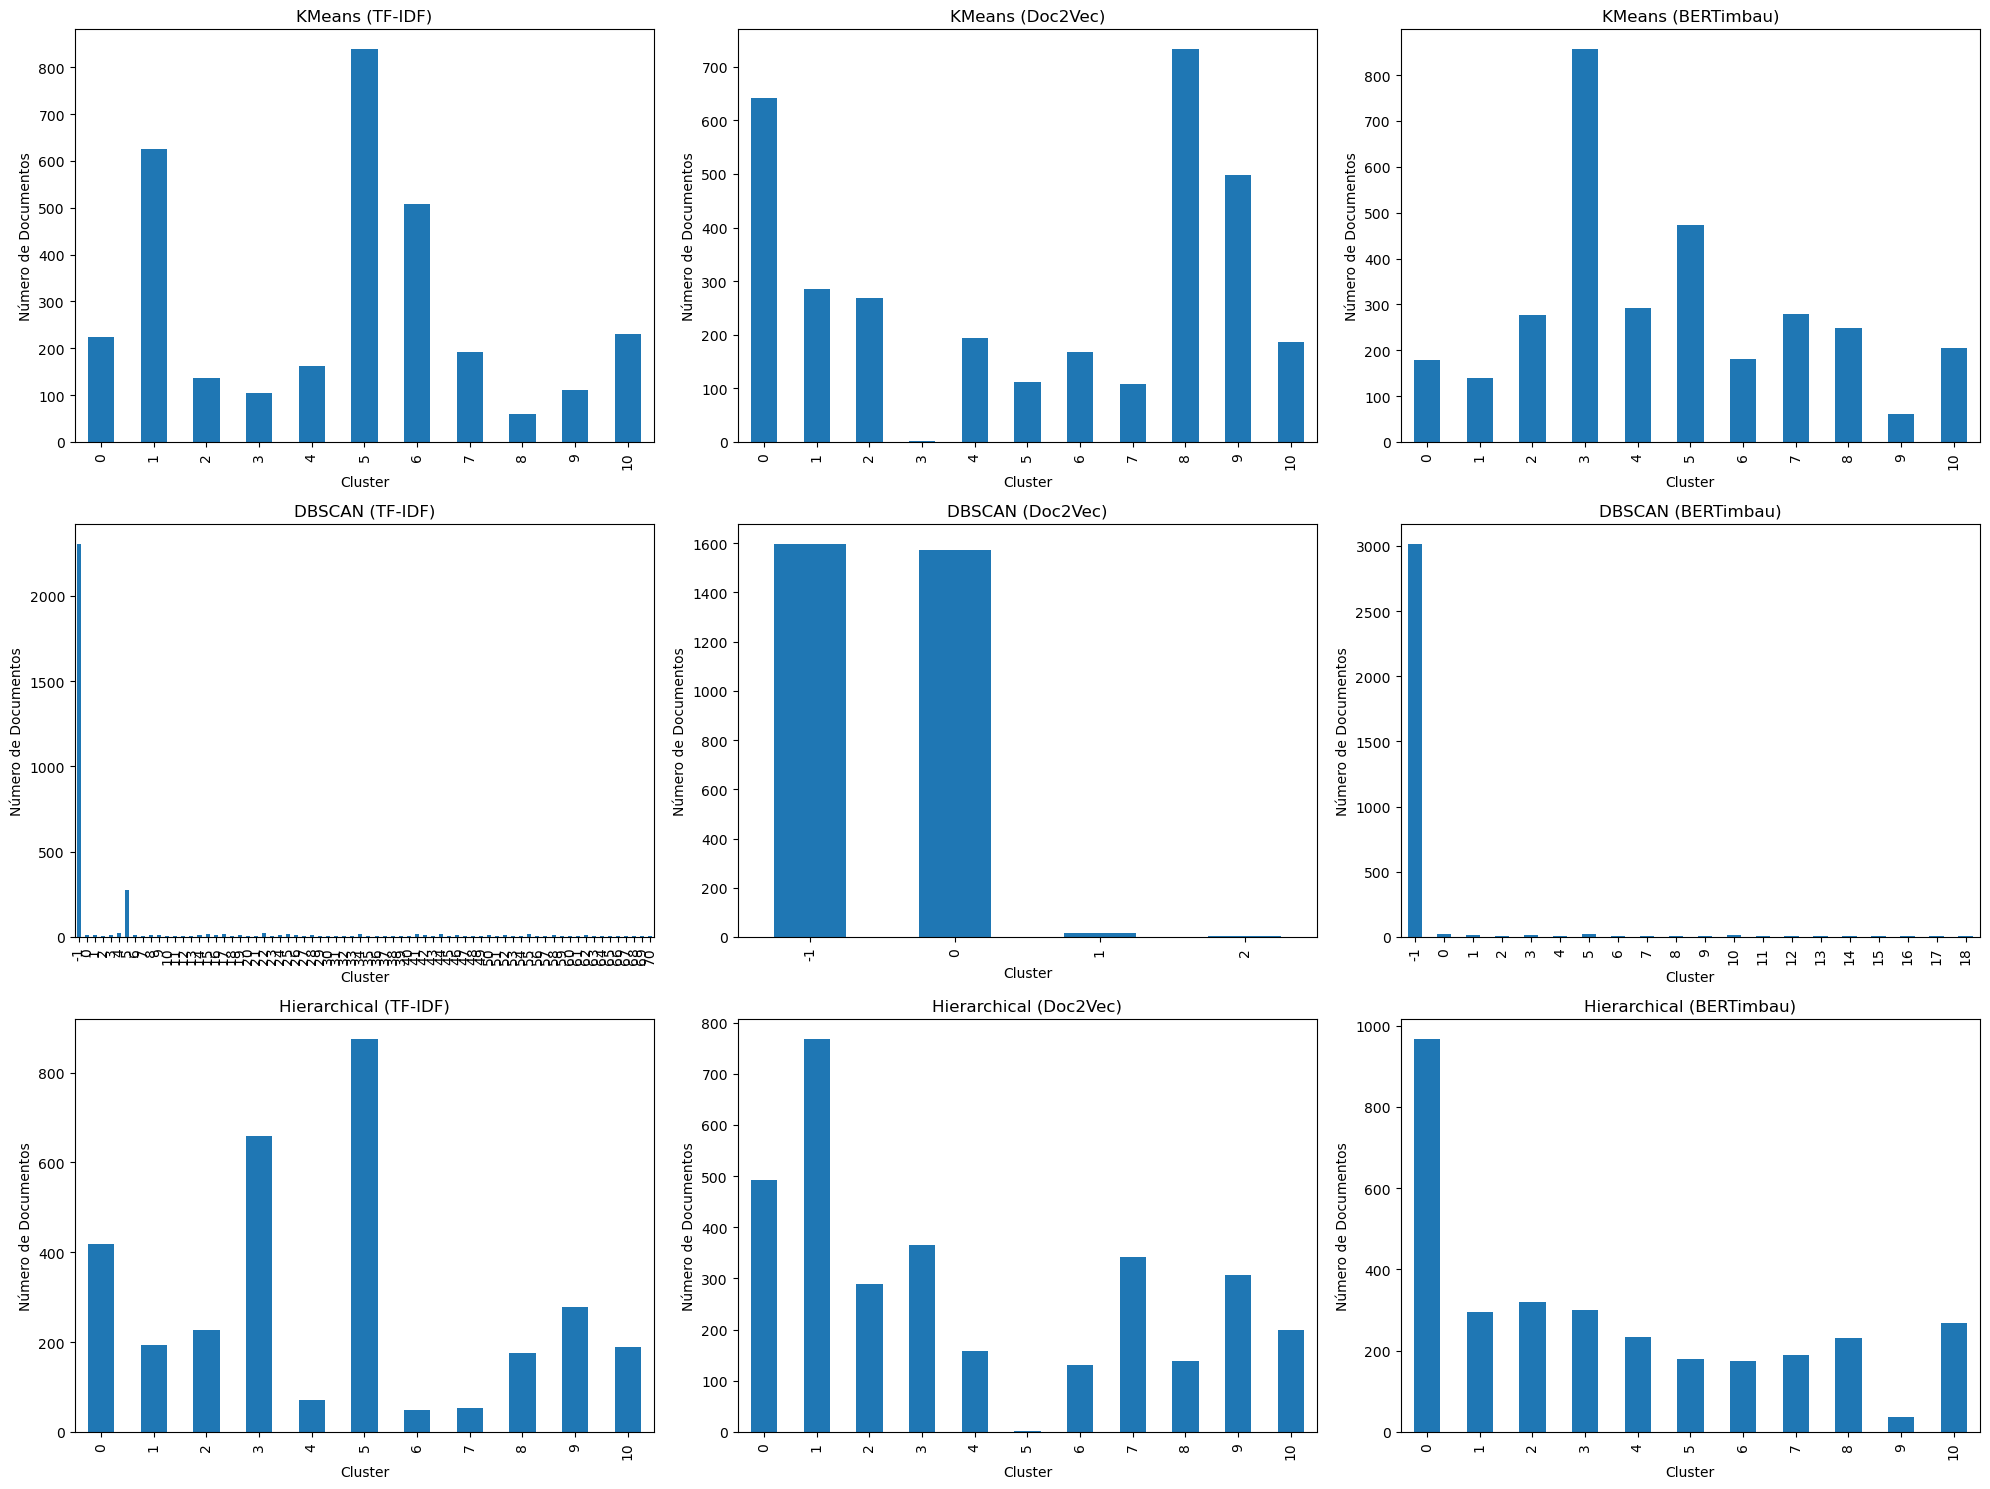

In [42]:
def compute_cluster_distributions(labels_list):
    """
    Calcula as distribuições de clusters para cada conjunto de rótulos.
    """
    distributions = []
    for labels in labels_list:
        distribution = pd.Series(labels).value_counts().sort_index()
        distributions.append(distribution)
    return distributions

def plot_cluster_distributions(distributions, titles_list):
    """
    Plota um grid de gráficos de barras mostrando a distribuição dos clusters.
    """
    plt.figure(figsize=(20, 15))
    
    for i, (distribution, title) in enumerate(zip(distributions, titles_list)):
        plt.subplot(3, 3, i+1)
        distribution.plot(kind='bar')
        plt.title(title)
        plt.xlabel('Cluster')
        plt.ylabel('Número de Documentos')
        
    plt.tight_layout()
    plt.show()

# Exemplo de uso
labels_list = [
    df['kmeans_labels_tfidf'], df['kmeans_labels_doc2vec'], df['kmeans_labels_bertimbau'],
    df['dbscan_labels_tfidf'], df['dbscan_labels_doc2vec'], df['dbscan_labels_bertimbau'],
    df['agg_labels_tfidf'], df['agg_labels_doc2vec'], df['agg_labels_bertimbau']
]
titles_list = [
    'KMeans (TF-IDF)', 'KMeans (Doc2Vec)', 'KMeans (BERTimbau)',
    'DBSCAN (TF-IDF)', 'DBSCAN (Doc2Vec)', 'DBSCAN (BERTimbau)',
    'Hierarchical (TF-IDF)', 'Hierarchical (Doc2Vec)', 'Hierarchical (BERTimbau)'
]

distributions = compute_cluster_distributions(labels_list)
plot_cluster_distributions(distributions, titles_list)

### Análise de Exemplos

In [43]:
def display_cluster_samples(df, label_column, num_clusters, num_samples=5):
    """
    Exibe amostras de documentos para cada cluster.

    Parâmetros:
    - df: DataFrame contendo os dados e rótulos dos clusters.
    - label_column: Nome da coluna contendo os rótulos dos clusters.
    - num_clusters: Número total de clusters.
    - num_samples: Número de amostras de documentos a serem exibidos para cada cluster.
    """
    for i in range(num_clusters):
        print(f"Cluster {i}:\n")
        print(df[df[label_column] == i]['summary'].head(num_samples))
        print("\n" + "="*50 + "\n")

In [45]:
def display_cluster_samples_for_all(df):
    # Definindo os pares (coluna, nome do método)
    methods = [
        ('kmeans_labels_tfidf', 'KMeans TF-IDF'),
        ('dbscan_labels_tfidf', 'DBSCAN TF-IDF'),
        ('agg_labels_tfidf', 'Hierarchical Clustering TF-IDF'),
        ('kmeans_labels_doc2vec', 'KMeans Doc2Vec'),
        ('dbscan_labels_doc2vec', 'DBSCAN Doc2Vec'),
        ('agg_labels_doc2vec', 'Hierarchical Clustering Doc2Vec'),
        ('kmeans_labels_bertimbau', 'KMeans BERTimbau'),
        ('dbscan_labels_bertimbau', 'DBSCAN BERTimbau'),
        ('agg_labels_bertimbau', 'Hierarchical Clustering BERTimbau'),
    ]
    
    # Iterando sobre os métodos e exibindo as amostras
    for column, method_name in methods:
        num_clusters = df[column].nunique()
        print(f"Samples for {method_name}:\n")
        display_cluster_samples(df, column, num_clusters)
        print("\n" + "="*100 + "\n")

# Executando a função
display_cluster_samples_for_all(df)

Samples for KMeans TF-IDF:

Cluster 0:

1     autoriza prefeitura ceder mediante concessão a...
8     empréstimo $ TOKEN_VALOR contraído caixa econô...
52    autoriza poder executivo contratar operação cr...
66    autoriza prefeitura municipal sorocaba renovar...
91    autoriza prefeitura municipal sorocaba repassa...
Name: summary, dtype: object


Cluster 1:

15    denominação natalio elias fernandes via públic...
16    denominação doutor décio tavares via pública c...
33     denominação nayla amari murad via pública cidade
38      denominarão tomekiti nishida via pública cidade
41          denominação miguel amato via pública cidade
Name: summary, dtype: object


Cluster 2:

12     altera redação memorial descritivo constante a...
32     revoga artigo # lei Nº # TOKEN_DATA autoriza f...
104        alteração alínea artigo # lei Nº # TOKEN_DATA
170    altera artigo # lei Nº # TOKEN_DATA   reformul...
216    acréscimo parágrafo único artigo único artigo ...
Name: summary, dtype: object


In [44]:
NUM_CLUSTERS_KMEANS_TFIDF = df['kmeans_labels_tfidf'].nunique()
display_cluster_samples(df, 'kmeans_labels_tfidf', NUM_CLUSTERS_KMEANS_TFIDF)

Cluster 0:

1     autoriza prefeitura ceder mediante concessão a...
8     empréstimo $ TOKEN_VALOR contraído caixa econô...
52    autoriza poder executivo contratar operação cr...
66    autoriza prefeitura municipal sorocaba renovar...
91    autoriza prefeitura municipal sorocaba repassa...
Name: summary, dtype: object


Cluster 1:

15    denominação natalio elias fernandes via públic...
16    denominação doutor décio tavares via pública c...
33     denominação nayla amari murad via pública cidade
38      denominarão tomekiti nishida via pública cidade
41          denominação miguel amato via pública cidade
Name: summary, dtype: object


Cluster 2:

12     altera redação memorial descritivo constante a...
32     revoga artigo # lei Nº # TOKEN_DATA autoriza f...
104        alteração alínea artigo # lei Nº # TOKEN_DATA
170    altera artigo # lei Nº # TOKEN_DATA   reformul...
216    acréscimo parágrafo único artigo único artigo ...
Name: summary, dtype: object


Cluster 3:

42     institu

## Conclusões



## Referências